In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import torch
from torch import Tensor
from torch.nn import AvgPool2d, Conv2d, Flatten, Linear, MaxPool2d, Module, Sequential, Tanh
import torch.nn.functional as F

from collections import OrderedDict
from typing import Callable, Type

In [ ]:
class LeNet(Module):
    model: Sequential

    def __init__(self,
                 subsampling: Type[Module] = AvgPool2d,
                 activation: Callable[[Tensor], Tensor] = Tanh):
        super().__init__()
        self.model = Sequential(OrderedDict([
            ('C1',      Conv2d(1, 6, kernel_size=(5, 5), padding='same')),
            ('C1-act',  activation()),
            ('S2',      subsampling(kernel_size=(2, 2), stride=(2, 2))),
            ('S2-act',  activation()),
            ('C3',      Conv2d(6, 16, kernel_size=(5, 5))),
            ('S4',      subsampling(kernel_size=(2, 2), stride=(2, 2))),
            ('S4-act',  activation()),
            ('C5',      Conv2d(16, 120, kernel_size=(5, 5))),
            ('C5-act',  activation()),
            ('Flatten', Flatten()),
            ('F6',      Linear(120, 84)),
            ('F6-act',  activation()),
            ('Output',  Linear(84, 10)),
            # Note: we skip softmax here because PyTorch will apply it for us,
            # since we are using CrossEntropyLoss. We have to manually apply
            # the softmax during evaluation to get the propabilities, or use
            # argmax() to find the class with the highest probability.
            #
            # ('Softmax', Softmax()),
        ]))

    def forward(self, data: Tensor) -> Tensor:
        return self.model(data)

In [ ]:
# Select GPU if available, or fall back to CPU.
def select_device():
    if torch.cuda.is_available():
        return 'cuda' # Nvidia GPU or AMD RocM
    elif torch.backends.mps.is_available():
        return 'mps'  # macOS GPU
    else:
        return 'cpu'  # CPU fallback

device = torch.device(select_device())
print(f'Using device: {device}\n')

# Create the model with default options.
model = LeNet(subsampling=MaxPool2d).to(device)
print(model)

Using device: cuda

LeNet(
  (model): Sequential(
    (C1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (C1-act): Tanh()
    (S2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (S2-act): Tanh()
    (C3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (S4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (S4-act): Tanh()
    (C5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (C5-act): Tanh()
    (Flatten): Flatten(start_dim=1, end_dim=-1)
    (F6): Linear(in_features=120, out_features=84, bias=True)
    (F6-act): Tanh()
    (Output): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
              Tanh-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
         MaxPool2d-6             [-1, 16, 5, 5]               0
              Tanh-7             [-1, 16, 5, 5]               0
            Conv2d-8            [-1, 120, 1, 1]          48,120
              Tanh-9            [-1, 120, 1, 1]               0
          Flatten-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             Tanh-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
Total params: 61,706
Trainable params: 

In [ ]:
%%capture --no-stderr

import torchvision
from torchvision.transforms import Compose, Lambda, ToTensor
from torchvision.datasets import MNIST

mnist_dir = 'mnist'

transform = Compose([
    ToTensor(),  # automatically scales image input from [0, 255] to [0, 1]
])

# Download MNIST and create train and test dataset splits.
train_data = MNIST(root=mnist_dir, train=True, download=True, transform=transform)
test_data = MNIST(root=mnist_dir, train=False, download=True, transform=transform)

batch_size = 16
shuffle = True
num_workers = 1

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [ ]:
print(f'Train x: {train_data.data.shape}')
print(f'      y: {train_data.targets.shape}')
print(f'Test  x: {test_data.data.shape}')
print(f'      y: {test_data.targets.shape}')

Train x: torch.Size([60000, 28, 28])
      y: torch.Size([60000])
Test  x: torch.Size([10000, 28, 28])
      y: torch.Size([10000])


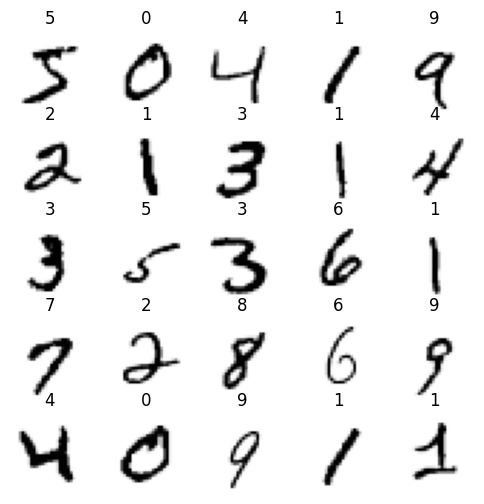

In [ ]:
# Visualize a few images and their labels.

from matplotlib import pyplot as plt

figure: plt.Figure = plt.figure(figsize=(6, 6))
rows, cols = 5, 5
for i in range(rows * cols):
    axes: plt.Axes = figure.add_subplot(rows, cols, i + 1)

    image = train_data.data[i]
    axes.imshow(image, cmap='Greys')

    label = train_data.targets[i].item()
    axes.set_title(label)
    axes.set_axis_off()

figure.show()

In [ ]:
# Train the model.

import time

learning_rate: float = 0.001
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
epochs: int = 30

print(f'Using device: {device}\n')

model.train()
for epoch in range(epochs):
    start_time: float = time.time()
    epoch_loss: float = 0.0
    num_batches: int = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        cost = loss(logits, targets)
        cost.backward()
        optimizer.step()
        epoch_loss += cost.item()
        num_batches += 1

    # Print stats after each epoch.
    per_batch_loss: float = epoch_loss / num_batches
    elapsed_time: float = time.time() - start_time
    print(' '.join([
        f'epoch {epoch + 1:>2,d}: epoch loss = {epoch_loss:>10,.6f},'
        f'per-batch loss: {per_batch_loss:.6f},'
        f'time elapsed: {elapsed_time:.2f} sec',
        ]))

Using device: cuda

epoch  1: epoch loss = 238.033361,per-batch loss: 0.063476,time elapsed: 21.47 sec
epoch  2: epoch loss = 165.941095,per-batch loss: 0.044251,time elapsed: 21.38 sec
epoch  3: epoch loss = 128.773172,per-batch loss: 0.034340,time elapsed: 21.76 sec
epoch  4: epoch loss = 101.661849,per-batch loss: 0.027110,time elapsed: 22.44 sec
epoch  5: epoch loss =  89.062441,per-batch loss: 0.023750,time elapsed: 20.96 sec
epoch  6: epoch loss =  82.796382,per-batch loss: 0.022079,time elapsed: 22.16 sec
epoch  7: epoch loss =  69.688406,per-batch loss: 0.018584,time elapsed: 21.38 sec
epoch  8: epoch loss =  63.099090,per-batch loss: 0.016826,time elapsed: 21.59 sec
epoch  9: epoch loss =  56.999508,per-batch loss: 0.015200,time elapsed: 20.91 sec
epoch 10: epoch loss =  53.119180,per-batch loss: 0.014165,time elapsed: 21.51 sec
epoch 11: epoch loss =  48.115312,per-batch loss: 0.012831,time elapsed: 21.64 sec
epoch 12: epoch loss =  54.589235,per-batch loss: 0.014557,time ela

In [ ]:
# Evaluate the model on the test set.

correct: int = 0
total: int = len(test_loader.dataset)
test_loss: float = 0
eval_start_time: float = time.time()

model.eval()
with torch.no_grad():
    for (inputs, targets) in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        predicted = logits.argmax(dim=1)
        correct += (predicted == targets).sum().item()
        test_loss += F.nll_loss(F.log_softmax(logits, dim=1), targets, reduction='sum').item()

print(f'Using device: {device}')
print(f'Average loss: {test_loss / total:.4f}')
print(f'Accuracy: {correct} / {total} ({100.0 * correct / total:.2f}%)')
print(f'Time elapsed: {time.time() - eval_start_time:.2f} sec')

Using device: cuda
Average loss: 0.0545
Accuracy: 9886 / 10000 (98.86%)
Time elapsed: 3.17 sec
